In [3]:
import yfinance as yf
import pandas as pd

In [25]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 📌 버핏 필터
def buffett_filters(info):
    try:
        roe = info.get('returnOnEquity', 0)
        pe = info.get('trailingPE', 0)
        debt = info.get('debtToEquity', 1000)  # 너무 크면 부적격
        op_cf = info.get('operatingCashflow', 0) or 0
        capex = info.get('capitalExpenditures', 0) or 0
        fcf = op_cf - capex
        margin = info.get('profitMargins', 0)

        return {
            "ROE": roe,
            "PER": pe,
            "DebtToEquity": debt,
            "ProfitMargin": margin,
            "FCF": fcf,
            "Pass": roe and roe > 0.15 and pe and pe < 20 and debt < 1.0
        }

    except Exception as e:
        print(f"❌ 필터 오류: {e}")
        return None

# 📌 DCF 계산
def dcf_value(info, growth_rate=0.08, discount_rate=0.10, terminal_growth=0.03):
    try:
        op_cf = info.get('operatingCashflow', 0) or 0
        capex = info.get('capitalExpenditures', 0) or 0
        fcf = op_cf - capex
        shares = info.get('sharesOutstanding', 1)
        price = info.get('currentPrice', 0)

        # 미래 현금흐름 추정
        cashflows = []
        for year in range(1, 6):
            fcf *= (1 + growth_rate)
            discounted = fcf / ((1 + discount_rate) ** year)
            cashflows.append(discounted)

        # Terminal value
        terminal = fcf * (1 + terminal_growth) / (discount_rate - terminal_growth)
        terminal /= ((1 + discount_rate) ** 5)

        total_value = sum(cashflows) + terminal
        intrinsic = total_value / shares

        return {
            "IntrinsicValue": intrinsic,
            "CurrentPrice": price,
            "Undervalued": intrinsic > price
        }

    except Exception as e:
        print(f"❌ DCF 계산 오류: {e}")
        return None

# 📌 전체 종목 분석
def analyze_tickers(tickers):
    results = []
    for ticker in tickers:
        print(f"🔍 {ticker} 분석 중...")
        try:
            stock = yf.Ticker(ticker)
            info = stock.info

            filt = buffett_filters(info)
            dcf = dcf_value(info)

            if filt and dcf:
                results.append({
                    "Ticker": ticker,
                    "Name": info.get('longName', ''),
                    "ROE (%)": round((filt["ROE"] or 0) * 100, 2),
                    "PER": round((filt["PER"] or 0), 2),
                    "D/E": round((filt["DebtToEquity"] or 0), 2),
                    "Profit Margin (%)": round((filt["ProfitMargin"] or 0) * 100, 2),
                    "Intrinsic Value": round(dcf["IntrinsicValue"], 2),
                    "Current Price": round(dcf["CurrentPrice"], 2),
                    "Undervalued": dcf["Undervalued"],
                    "Pass Filter": filt["Pass"]
                })
        except Exception as e:
            print(f"⚠️ {ticker} 분석 실패: {e}")

    df = pd.DataFrame(results)
    if not df.empty:
        df.sort_values(by=["Pass Filter", "Undervalued"], ascending=False, inplace=True)
    return df


In [30]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "BRK-B", "NVDA", "JPM", "V"]
df = analyze_tickers(tickers)
print(df)


🔍 AAPL 분석 중...
🔍 MSFT 분석 중...
🔍 GOOGL 분석 중...
🔍 AMZN 분석 중...
🔍 TSLA 분석 중...
🔍 META 분석 중...
🔍 BRK-B 분석 중...
🔍 NVDA 분석 중...
🔍 JPM 분석 중...
🔍 V 분석 중...
  Ticker                     Name  ROE (%)     PER      D/E  \
2  GOOGL            Alphabet Inc.    34.79   19.93     8.25   
5   META     Meta Platforms, Inc.    39.84   28.66    26.76   
0   AAPL               Apple Inc.   138.01   31.37   146.99   
1   MSFT    Microsoft Corporation    33.61   38.33    32.63   
3   AMZN         Amazon.com, Inc.    25.24   36.37    51.64   
4   TSLA              Tesla, Inc.     8.77  185.02    17.41   
6  BRK-B  Berkshire Hathaway Inc.    13.19   12.95    19.18   
7   NVDA       NVIDIA Corporation   115.46   50.72    12.27   
8    JPM     JPMorgan Chase & Co.    17.35   14.09  1000.00   
9      V                Visa Inc.    50.65   35.07    54.59   

   Profit Margin (%)  Intrinsic Value  Current Price  Undervalued  Pass Filter  
2              30.86           413.71         178.53         True        Fals

🔍 AAPL 분석 중...
🔍 MSFT 분석 중...
🔍 GOOGL 분석 중...
🔍 AMZN 분석 중...
🔍 TSLA 분석 중...
🔍 META 분석 중...
🔍 BRK-B 분석 중...
🔍 NVDA 분석 중...
🔍 JPM 분석 중...
🔍 V 분석 중...
  Ticker                     Name  ROE (%)     PER      D/E  \
2  GOOGL            Alphabet Inc.    34.79   19.93     8.25   
5   META     Meta Platforms, Inc.    39.84   28.66    26.76   
0   AAPL               Apple Inc.   138.01   31.37   146.99   
1   MSFT    Microsoft Corporation    33.61   38.33    32.63   
7   NVDA       NVIDIA Corporation   115.46   50.72    12.27   
9      V                Visa Inc.    50.65   35.07    54.59   
3   AMZN         Amazon.com, Inc.    25.24   36.37    51.64   
8    JPM     JPMorgan Chase & Co.    17.35   14.09  1000.00   
6  BRK-B  Berkshire Hathaway Inc.    13.19   12.95    19.18   
4   TSLA              Tesla, Inc.     8.77  185.02    17.41   

   Profit Margin (%)  Revenue Growth (%)  Dividend Yield (%)  Intrinsic Value  \
2              30.86                12.0                47.0           413.71

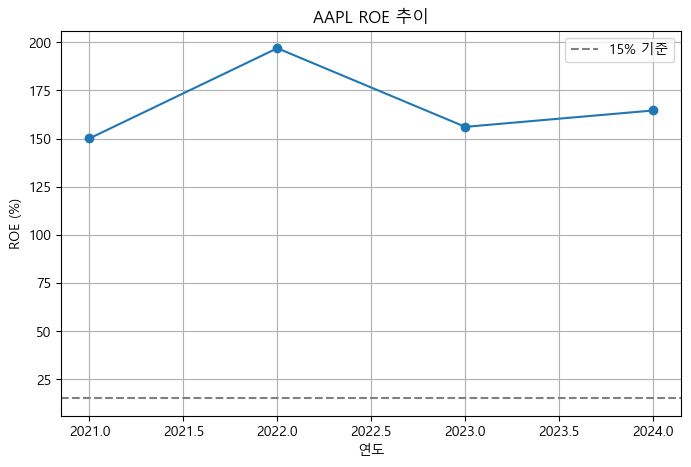

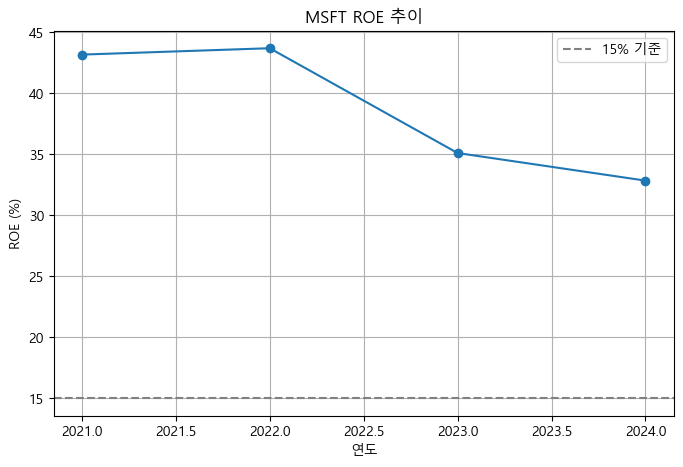

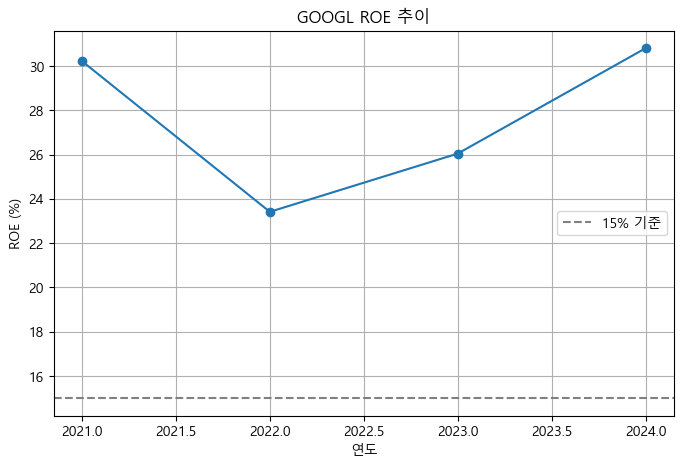

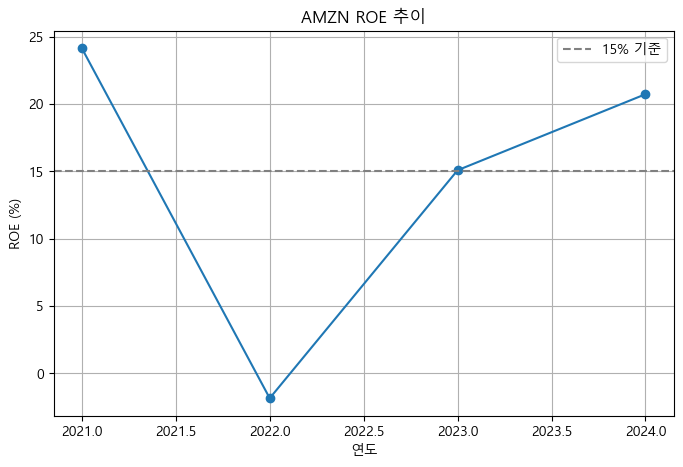

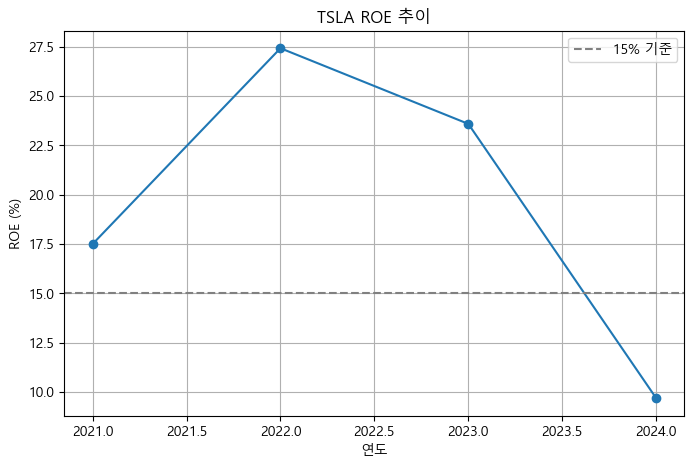

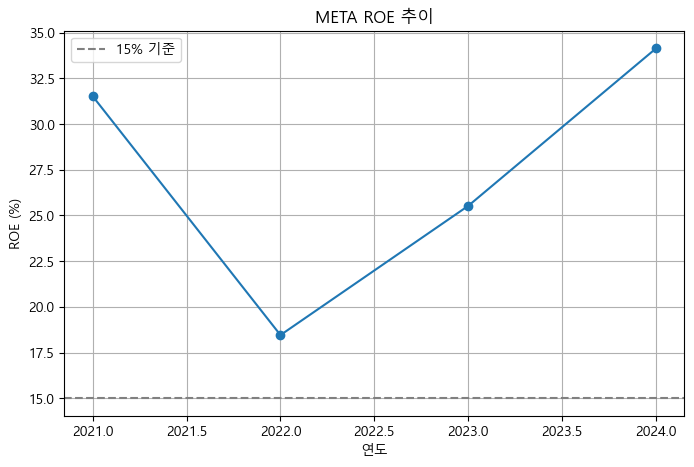

c:\Git\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


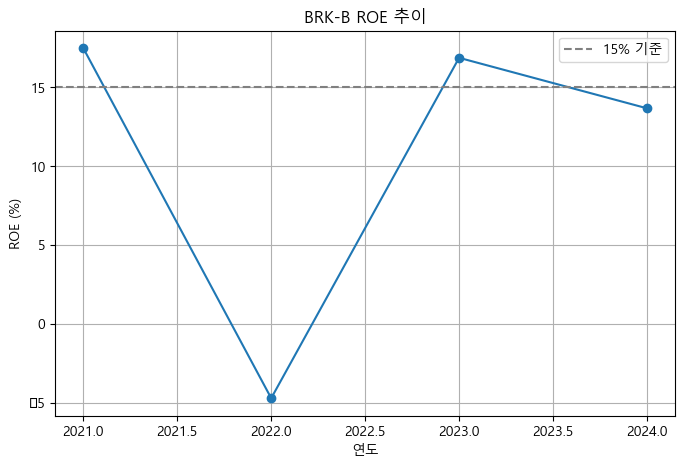

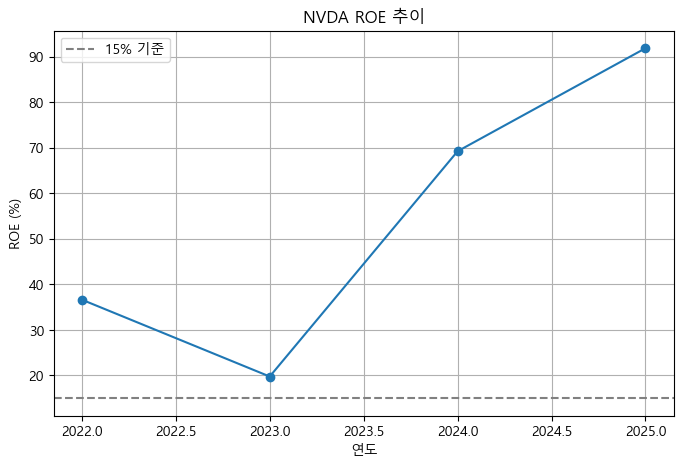

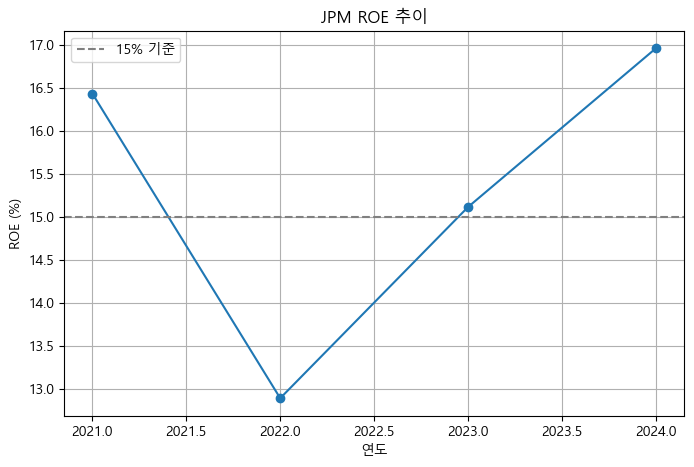

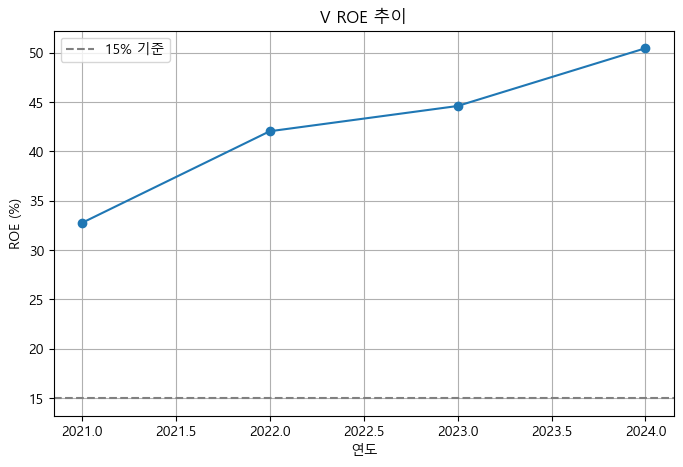

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 설치된 한글 폰트 경로 설정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams["font.family"] = font_name


import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 확장된 버핏 필터
def extended_buffett_filters(info):
    try:
        roe = info.get('returnOnEquity', 0)
        pe = info.get('trailingPE', 0)
        debt = info.get('debtToEquity', 1000)
        op_cf = info.get('operatingCashflow', 0) or 0
        capex = info.get('capitalExpenditures', 0) or 0
        fcf = op_cf - capex
        margin = info.get('profitMargins', 0)
        revenue_growth = info.get('revenueGrowth', 0)
        dividend_yield = info.get('dividendYield', 0)

        return {
            "ROE": roe,
            "PER": pe,
            "DebtToEquity": debt,
            "ProfitMargin": margin,
            "FCF": fcf,
            "RevenueGrowth": revenue_growth,
            "DividendYield": dividend_yield,
            "Pass": roe and roe > 0.15 and pe and pe < 20 and debt < 1.0 and fcf > 0 and margin > 0.1
        }
    except Exception as e:
        print(f"❌ 필터 오류: {e}")
        return None

# ✅ DCF 계산
def dcf_value(info, growth_rate=0.08, discount_rate=0.10, terminal_growth=0.03):
    try:
        op_cf = info.get('operatingCashflow', 0) or 0
        capex = info.get('capitalExpenditures', 0) or 0
        fcf = op_cf - capex
        shares = info.get('sharesOutstanding', 1)
        price = info.get('currentPrice', 0)

        cashflows = []
        for year in range(1, 6):
            fcf *= (1 + growth_rate)
            discounted = fcf / ((1 + discount_rate) ** year)
            cashflows.append(discounted)

        terminal = fcf * (1 + terminal_growth) / (discount_rate - terminal_growth)
        terminal /= ((1 + discount_rate) ** 5)

        total_value = sum(cashflows) + terminal
        intrinsic = total_value / shares

        return {
            "IntrinsicValue": intrinsic,
            "CurrentPrice": price,
            "Undervalued": intrinsic > price
        }

    except Exception as e:
        print(f"❌ DCF 오류: {e}")
        return None

# ✅ ROE 시각화 (다중 후보 필드 처리 포함)
def plot_historical_roe(ticker):
    stock = yf.Ticker(ticker)
    try:
        financials = stock.financials.T
        balance_sheet = stock.balance_sheet.T

        net_income = None
        for key in ['Net Income', 'NetIncomeApplicableToCommonShares']:
            if key in financials.columns:
                net_income = financials[key]
                break

        equity = None
        for key in ['Total Stockholder Equity', 'Total Equity Gross Minority Interest']:
            if key in balance_sheet.columns:
                equity = balance_sheet[key]
                break

        if net_income is None or equity is None:
            raise ValueError("📉 'Net Income' 또는 'Total Stockholder Equity' 유사 항목 없음")

        roe = (net_income / equity).dropna() * 100
        roe = roe.sort_index()

        if roe.empty:
            raise ValueError("📉 ROE 계산 불가능 (비어있음)")

        plt.figure(figsize=(8, 5))
        plt.plot(roe.index.year, roe.values, marker='o')
        plt.title(f"{ticker} ROE 추이")
        plt.xlabel("연도")
        plt.ylabel("ROE (%)")
        plt.axhline(15, color='gray', linestyle='--', label='15% 기준')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"⚠️ {ticker} ROE 시각화 오류: {e}")

# ✅ 점수화 시스템
def score_company(filt):
    score = 0
    if filt["ROE"] and filt["ROE"] > 0.15: score += 1
    if filt["PER"] and filt["PER"] < 20: score += 1
    if filt["DebtToEquity"] and filt["DebtToEquity"] < 1.0: score += 1
    if filt["ProfitMargin"] and filt["ProfitMargin"] > 0.1: score += 1
    if filt["FCF"] and filt["FCF"] > 0: score += 1
    if filt["RevenueGrowth"] and filt["RevenueGrowth"] > 0.05: score += 1
    if filt["DividendYield"] and filt["DividendYield"] > 0.01: score += 1
    return score

# ✅ 종목 분석 통합 실행
def analyze_companies(tickers):
    results = []
    for ticker in tickers:
        print(f"🔍 {ticker} 분석 중...")
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            filt = extended_buffett_filters(info)
            dcf = dcf_value(info)
            score = score_company(filt) if filt else 0

            if filt and dcf:
                results.append({
                    "Ticker": ticker,
                    "Name": info.get('longName', ''),
                    "ROE (%)": round((filt["ROE"] or 0) * 100, 2),
                    "PER": round((filt["PER"] or 0), 2),
                    "D/E": round((filt["DebtToEquity"] or 0), 2),
                    "Profit Margin (%)": round((filt["ProfitMargin"] or 0) * 100, 2),
                    "Revenue Growth (%)": round((filt["RevenueGrowth"] or 0) * 100, 2),
                    "Dividend Yield (%)": round((filt["DividendYield"] or 0) * 100, 2),
                    "Intrinsic Value": round(dcf["IntrinsicValue"], 2),
                    "Current Price": round(dcf["CurrentPrice"], 2),
                    "Undervalued": dcf["Undervalued"],
                    "Pass Filter": filt["Pass"],
                    "Score": score
                })
        except Exception as e:
            print(f"⚠️ {ticker} 분석 실패: {e}")

    df = pd.DataFrame(results)
    if not df.empty:
        df.sort_values(by=["Score", "Undervalued"], ascending=False, inplace=True)
    return df

# ✅ 실행 예시
if __name__ == "__main__":
    tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "BRK-B", "NVDA", "JPM", "V"]
    df = analyze_companies(tickers)
    print(df)

    # ROE 시각화 테스트
    for ticker in tickers:
        plot_historical_roe(ticker)